# RandomForest Exoplanet Classification using Cumulative Object of Interest Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 75)

## RandomForest Classifier


In [3]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, cross_validate

Read pickle files from Data Prep.

In [18]:
#Read Pickle Files
#try:
#    del df_rfecvTrainFillX, df_rfecvTestFillX, df_rfecvTrainMiceX, df_rfecvTestMiceX, topExoTrainFillX, topExoTestFillX, topExoTrainMiceX, topExoTestMiceX
#except Exception as e:
#    print(e)
    
df_scaledTrainFillX = pd.read_pickle("./pkl/df_scaledTrainFillX.pkl")
df_scaledTestFillX = pd.read_pickle("./pkl/df_scaledTestFillX.pkl")
df_scaledTrainMiceX = pd.read_pickle("./pkl/df_scaledTrainMiceX.pkl")
df_scaledTestMiceX = pd.read_pickle("./pkl/df_scaledTestMiceX.pkl")

exoTestFillX = pd.read_pickle("./pkl/exoTestFillX.pkl")
exoTrainFillX = pd.read_pickle("./pkl/exoTrainFillX.pkl")
exoTestMiceX = pd.read_pickle("./pkl/exoTestMiceX.pkl")
exoTrainMiceX = pd.read_pickle("./pkl/exoTrainMiceX.pkl")
exoTrainX = pd.read_pickle('./pkl/exoTrainX.pkl')
exoTestX = pd.read_pickle('./pkl/exoTestX.pkl')

#Response Variables
exoTrainFillY = pd.read_pickle("./pkl/exoTrainFillY.pkl")
exoTestFillY = pd.read_pickle("./pkl/exoTestFillY.pkl")
exoTrainMiceY = pd.read_pickle("./pkl/exoTrainMiceY.pkl")
exoTestMiceY = pd.read_pickle("./pkl/exoTestMiceY.pkl")
exoTestY = pd.read_pickle("./pkl/exoTestY.pkl")
exoTrainY = pd.read_pickle("./pkl/exoTrainY.pkl")

In [19]:
exoTestFillX.drop(['koi_count'], inplace=True, axis=1)
exoTrainFillX.drop(['koi_count'], inplace=True, axis=1)

exoTrainMiceX.drop(['koi_count'], inplace=True, axis=1)
exoTestMiceX.drop(['koi_count'], inplace=True, axis=1)

df_scaledTrainFillX.drop(['koi_count'], inplace=True, axis=1)
df_scaledTestFillX.drop(['koi_count'], inplace=True, axis=1)

df_scaledTrainMiceX.drop(['koi_count'], inplace=True, axis=1)
df_scaledTestMiceX.drop(['koi_count'], inplace=True, axis=1)

#### RandomForest Classifier Function

In [11]:
def runModelCV(X, y, cv, clf, varImp = True):
    imps = list()
    accList = list()
    i = 1
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]  
        clf.fit(X_train, y_train)
        acc = clf.score(X_test, y_test)
        accList.append(acc)
        print("Model", i, "Accuracy:", acc)
        imps.append(clf.feature_importances_)
        i += 1
    
    print("Mean Accuracy Across Models: ",np.mean(np.asarray(accList)))
    
    if(varImp):
        fig, ax = plt.subplots(figsize=(15,10))
        im = ax.imshow(imps)

        ax.set_xticks(np.arange(X.shape[1]))
        ax.set_yticks(np.arange(i - 1))
        ax.set_xticklabels(list(X))
        ax.set_yticklabels(np.arange(i) + 1)
        ax.set_xlabel("Feature")
        ax.set_ylabel("Model")
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        ax.set_title("Comparison of Variable Importance Across CV Runs")
        fig.tight_layout()
        plt.show()

#### GridSearchCV

In [7]:
%%time

#GridSearchCV SVC
from sklearn.model_selection import GridSearchCV

#Create Cross Validation Objects
#cvss = ShuffleSplit(n_splits = 10, test_size=0.20, random_state=0)
cvsss = StratifiedShuffleSplit(n_splits = 5, test_size=0.20, random_state=0)
cv = StratifiedKFold(n_splits=5)

rfEst = RandomForestClassifier()

parameters = { 'n_estimators':[100, 200, 300, 400, 500]
              ,'max_features': [None, "auto", "sqrt", "log2"]
              #,'min_samples_split': [20, 50, 100, 200]
              , 'max_depth': [5, 10, 15]
              , 'min_samples_leaf': [5, 10, 20]
              ,'random_state': [0]
             }

#Create a grid search object using the  
regGridSearch = GridSearchCV(estimator=rfEst
                   , n_jobs=-1 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   #, cv=cv
                   , cv=cvsss
                   , scoring='recall') #'accuracy' 'f1' 'recall'


CPU times: user 215 µs, sys: 59 µs, total: 274 µs
Wall time: 278 µs


In [7]:
%%time
#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(exoTrainFillX, exoTrainFillY)
print(regGridSearch.best_params_, regGridSearch.best_score_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 56.2min finished


{'random_state': 0, 'max_depth': 15, 'n_estimators': 400, 'min_samples_leaf': 5, 'max_features': None} 0.9856521739130435


###### SAVED:  Stratified K Fold = 10 splits
Fitting 10 folds for each of 240 candidates, totalling 2400 fits
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 39.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 97.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 147.3min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 169.9min finished

{'max_features': 'auto', 'max_depth': 10, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 0} 0.991454188848417

CPU times: user 34.9 s, sys: 3.07 s, total: 38 s
Wall time: 2h 49min 54s

##### SAVED:  StratifiedShuffleSplit 5 splits
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 52.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 55.4min finished

{'min_samples_leaf': 5, 'max_features': None, 'max_depth': 15, 'random_state': 0, 'n_estimators': 400} 0.9856521739130435

CPU times: user 1min 4s, sys: 946 ms, total: 1min 5s
Wall time: 56min 16s

In [8]:
#regGridSearch.fit(exoTrainMiceX, exoTrainMiceY)
#print(regGridSearch.best_params_, regGridSearch.best_score_)
regGridSearch.best_estimator_

dict_values([0, 15, 400, 5, None])

### RandomForest Modeling for Different Missing Value Strategies

Zero Filled
Model 1 Accuracy: 0.9953314659197012
Model 2 Accuracy: 0.9967320261437909
Model 3 Accuracy: 0.992530345471522
Model 4 Accuracy: 0.9943977591036415
Model 5 Accuracy: 0.9957983193277311
Model 6 Accuracy: 0.9957983193277311
Model 7 Accuracy: 0.9957983193277311
Model 8 Accuracy: 0.9939309056956116
Model 9 Accuracy: 0.9957983193277311
Model 10 Accuracy: 0.9953314659197012
Mean Accuracy Across Models:  0.9951447245564893


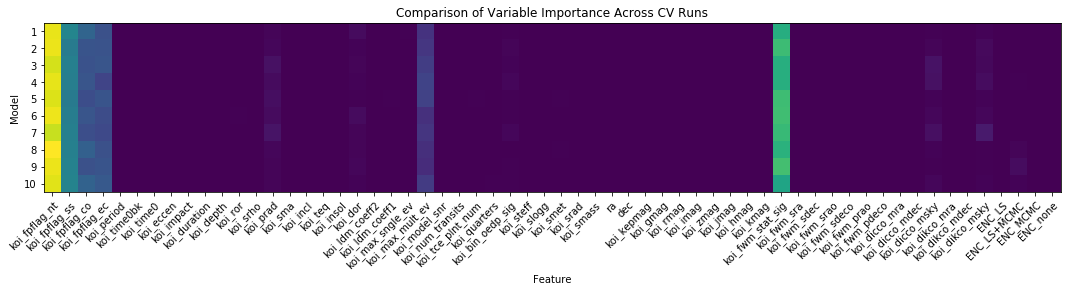

CPU times: user 6min 56s, sys: 1.43 s, total: 6min 58s
Wall time: 1min 51s


In [12]:
%%time
print("Zero Filled")
runModelCV(exoTrainFillX, exoTrainFillY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(min_samples_leaf=10, max_features=None, n_estimators=400, max_depth=8, random_state=0, n_jobs=-1))

KNN Imputation
Model 1 Accuracy: 0.988795518207283
Model 2 Accuracy: 0.9897292250233427
Model 3 Accuracy: 0.9831932773109243
Model 4 Accuracy: 0.9850606909430439
Model 5 Accuracy: 0.9850606909430439
Model 6 Accuracy: 0.9915966386554622
Model 7 Accuracy: 0.9883286647992531
Model 8 Accuracy: 0.9878618113912232
Model 9 Accuracy: 0.9901960784313726
Model 10 Accuracy: 0.9897292250233427
Mean Accuracy Across Models:  0.9879551820728292


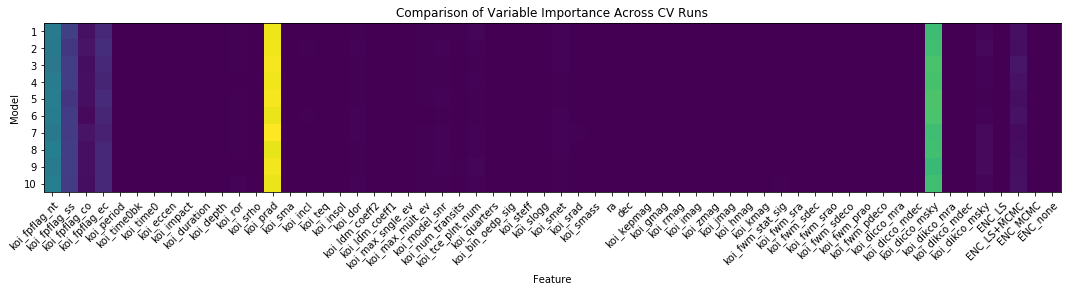

CPU times: user 9min 50s, sys: 1.39 s, total: 9min 51s
Wall time: 2min 34s


In [16]:
%%time
print("KNN Imputation")
runModelCV(exoTrainMiceX, exoTrainMiceY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(min_samples_leaf=5, max_features=None, n_estimators=400, max_depth=15, random_state=0, n_jobs=-1))

Scaled Zero Filled
Model 1 Accuracy: 0.9957983193277311
Model 2 Accuracy: 0.9985994397759104
Model 3 Accuracy: 0.9939309056956116
Model 4 Accuracy: 0.9948646125116714
Model 5 Accuracy: 0.9967320261437909
Model 6 Accuracy: 0.9967320261437909
Model 7 Accuracy: 0.9957983193277311
Model 8 Accuracy: 0.9957983193277311
Model 9 Accuracy: 0.9967320261437909
Model 10 Accuracy: 0.9971988795518207
Mean Accuracy Across Models:  0.996218487394958


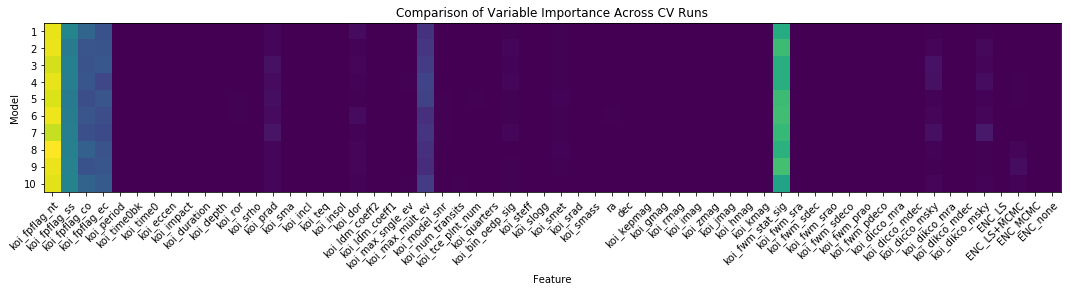

CPU times: user 7min 10s, sys: 1.54 s, total: 7min 12s
Wall time: 1min 54s


In [17]:
%%time
print("Scaled Zero Filled")
runModelCV(df_scaledTrainFillX, exoTrainFillY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(min_samples_leaf=5, max_features=None, n_estimators=400, max_depth=15, random_state=0, n_jobs=-1))

Scaled KNN Imputation
Model 1 Accuracy: 0.988795518207283
Model 2 Accuracy: 0.9897292250233427
Model 3 Accuracy: 0.9831932773109243
Model 4 Accuracy: 0.9850606909430439
Model 5 Accuracy: 0.9850606909430439
Model 6 Accuracy: 0.9915966386554622
Model 7 Accuracy: 0.9883286647992531
Model 8 Accuracy: 0.9878618113912232
Model 9 Accuracy: 0.9901960784313726
Model 10 Accuracy: 0.9897292250233427
Mean Accuracy Across Models:  0.9879551820728292


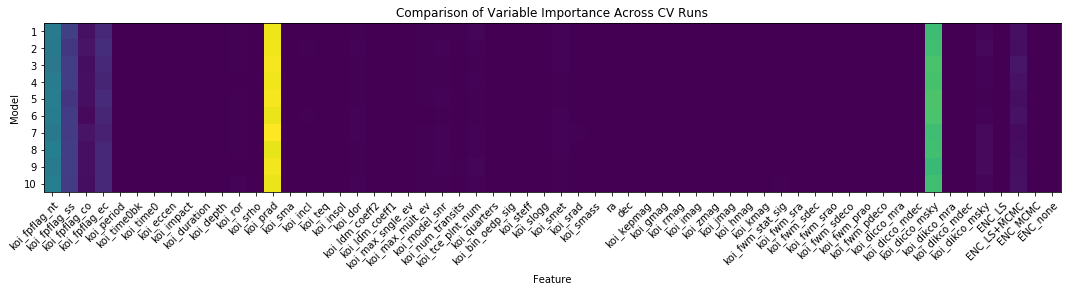

CPU times: user 9min 55s, sys: 1.57 s, total: 9min 56s
Wall time: 2min 35s


In [20]:
%%time
print("Scaled KNN Imputation")
runModelCV(df_scaledTrainMiceX, exoTrainMiceY, StratifiedShuffleSplit(n_splits = 10, test_size = 0.3, train_size=0.7, random_state=0),
          RandomForestClassifier(min_samples_leaf=5, max_features=None, n_estimators=400, max_depth=15, random_state=0, n_jobs=-1))

### Generate Graphics and Predictions

In [21]:
#From https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

from sklearn.tree import export_graphviz

#rfClf = RandomForestClassifier(n_estimators=400, max_depth=9, min_samples_split=100, random_state=0,  n_jobs=-1)
#rfClf = RandomForestClassifier(max_features='auto', n_estimators=100, max_depth=10, min_samples_split=20, random_state=0,  n_jobs=-1)
rfClf = RandomForestClassifier(min_samples_leaf=10, max_features=None, n_estimators=300, max_depth=8, random_state=0, n_jobs=-1)

rfClf.fit(exoTrainFillX, exoTrainFillY)
rfYHat = rfClf.predict(exoTrainFillX)
acc = mt.accuracy_score(exoTrainFillY, rfYHat)
conf = mt.confusion_matrix(exoTrainFillY,rfYHat)
prec = mt.precision_score(exoTrainFillY, rfYHat)
recall = mt.recall_score(exoTrainFillY, rfYHat)
f1 = mt.f1_score(exoTrainFillY, rfYHat)
rocAuc = mt.roc_auc_score(exoTrainFillY, rfYHat)
print('accuracy:', acc.round(4))
print('precision:', prec.round(4))
print('recall:', recall.round(4))
print('F1:', f1.round(4))
print('ROC AUC:', rocAuc.round(4))
print(conf)    


accuracy: 0.9962
precision: 0.9996
recall: 0.9887
F1: 0.9941
ROC AUC: 0.9942
[[4840    1]
 [  26 2271]]


       importance
count   60.000000
mean     0.016667
std      0.059844
min      0.000000
25%      0.000032
50%      0.000081
75%      0.000587
max      0.360618


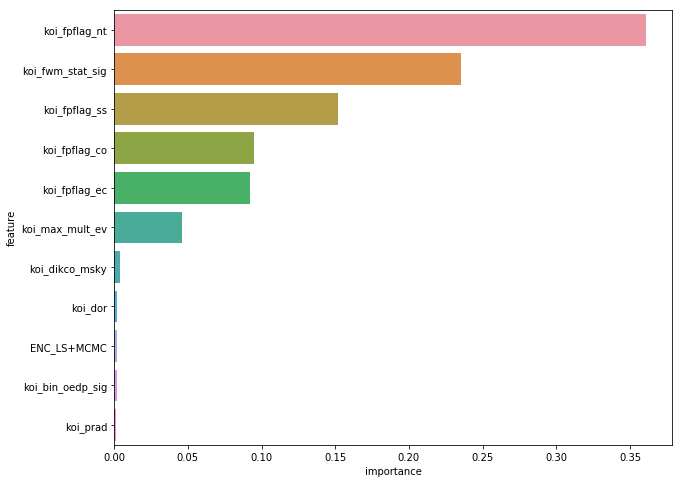

In [22]:
#Feature Importance Bar Plot
fi = pd.DataFrame({'feature': list(exoTrainFillX.columns),
                   'importance': rfClf.feature_importances_}).\
                    sort_values('importance', ascending = False)

print(fi.describe())
fi = fi[fi.importance > 0.001194]
    
plt.figure(figsize=(10,8))
ax = sns.barplot(x='importance', y='feature', data=fi)

In [26]:
export_graphviz(rfClf.estimators_[5], out_file='treeDropKOICount.dot', feature_names=exoTrainFillX.columns, 
                class_names=["FALSE POSITIVE", "EXOPLANET"], rounded=True, proportion=False, precision=2, filled=True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'treeDropKOICount.dot', '-o', 'treeDropKOICount.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'treeDropKOICount.png')

In [27]:
#rfClf.feature_importances_
rfYHat

array([1, 1, 0, ..., 0, 0, 0])

In [28]:
yHat = rfClf.predict_proba(exoTestFillX)

In [29]:
yHat = pd.DataFrame(yHat)
print("Greater Than 90%", np.count_nonzero(np.where(yHat[1] > 0.9)))
print("Greater Than 95%", np.count_nonzero(np.where(yHat[1] > 0.95)))

Greater Than 90% 1250
Greater Than 95% 1144


In [30]:
yHat.describe()

0            1
count  2426.000000  2426.000000
mean      0.201399     0.798601
std       0.259262     0.259262
min       0.000002     0.000000
25%       0.000669     0.674724
50%       0.085086     0.914914
75%       0.325276     0.999331
max       1.000000     0.999998

In [31]:
exoTestX_kepid = pd.read_pickle("./pkl/exoTestX_kepid.pkl")
exoTestX_kepid.describe()

count    2.426000e+03
mean     7.861219e+06
std      2.697777e+06
min      1.025986e+06
25%      5.786790e+06
50%      8.164700e+06
75%      9.988798e+06
max      1.288521e+07
Name: kepid, dtype: float64

In [32]:
dfKepID = pd.DataFrame(exoTestX_kepid.reset_index())
dfYHat = pd.DataFrame(yHat)

In [33]:
#join candidate kepler IDs to calculated probabilities
exoplanetsProb = dfKepID.join(dfYHat, how='outer')
exoplanetsProb.head()

index     kepid         0         1
0      2  10811496  0.000002  0.999998
1     37  11138155  0.000002  0.999998
2     58  11818800  0.000002  0.999998
3     62  11918099  0.000889  0.999111
4     63   9579641  0.154061  0.845939

In [34]:
exoplanetsProb.columns = ['cumOOI_index', 'kepid', 'prob0', 'prob1']
exoplanetsProb.head()

cumOOI_index     kepid     prob0     prob1
0             2  10811496  0.000002  0.999998
1            37  11138155  0.000002  0.999998
2            58  11818800  0.000002  0.999998
3            62  11918099  0.000889  0.999111
4            63   9579641  0.154061  0.845939

In [35]:
exoplanetsProb.sort_values(by=['prob1'], ascending=False, inplace=True)

In [37]:
exoplanetsProb.to_csv("./data/RFResultsDropKoiCount.csv")